<a href="https://colab.research.google.com/github/Niharika-Saha/Adaptive-Bacterial-Antibiotic-Resistance-Prediction-using-Meta-Learning/blob/experiments/expt1_metaopnet_megares_to_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Build CARD ARO → labels table (amr_gene_family / drug_class / mechanism)
import pandas as pd, numpy as np

# If you uploaded files individually into the working dir:
ARO_INDEX_PATH = "aro_index.tsv"          # required
ARO_CATEGORIES_PATH = "aro_categories.tsv"  # optional
OUT_PATH = "label_map.csv"

# 1) Load aro_index.tsv
idx = pd.read_csv(ARO_INDEX_PATH, sep="\t", dtype=str, engine="python")
idx.columns = [c.strip().lower().replace(" ", "_") for c in idx.columns]

def pick(cols, *keys):
    """Return the first column whose name contains ALL substrings in keys."""
    for c in cols:
        if all(k in c for k in keys):
            return c
    return None

aro_col  = pick(idx.columns, "aro", "accession")                 # e.g., "aro_accession"
name_col = pick(idx.columns, "aro", "name") or pick(idx.columns, "card", "short", "name")
fam_col  = pick(idx.columns, "amr", "gene", "family")            # e.g., "amr_gene_family"
drug_col = pick(idx.columns, "drug", "class")                    # e.g., "drug_class"
mech_col = pick(idx.columns, "resistance", "mechanism")          # e.g., "resistance_mechanism"

need = [aro_col, name_col, fam_col, drug_col, mech_col]
assert all(n is not None for n in need), f"Missing columns. Got: {dict(zip(['aro','name','fam','drug','mech'], need))}"

df = idx[[aro_col, name_col, fam_col, drug_col, mech_col]].copy()
df.columns = ["aro_accession","aro_name","amr_gene_family","drug_class","mechanism"]

# Normalize multi-valued fields
for c in ["amr_gene_family","drug_class","mechanism","aro_name"]:
    df[c] = df[c].fillna("NA").astype(str).str.strip()

def normalize_multi(x):
    parts = [p.strip() for p in str(x).replace("|",";").split(";") if p and p.strip()!="NA"]
    return "|".join(sorted(set(parts))) if parts else "NA"

df["amr_gene_family"] = df["amr_gene_family"].map(normalize_multi)
df["drug_class"]      = df["drug_class"].map(normalize_multi)
df["mechanism"]       = df["mechanism"].map(normalize_multi)

# 2) Collapse to one row per ARO accession
agg = (
    df.groupby(["aro_accession"], as_index=False)
      .agg({
          "aro_name":        lambda s: sorted(set(s.dropna()))[0] if len(set(s.dropna())) else "NA",
          "amr_gene_family": lambda s: normalize_multi("|".join(s.dropna())),
          "drug_class":      lambda s: normalize_multi("|".join(s.dropna())),
          "mechanism":       lambda s: normalize_multi("|".join(s.dropna())),
      })
)

# 3) Optional backfill from aro_categories.tsv if present
try:
    cat = pd.read_csv(ARO_CATEGORIES_PATH, sep="\t", dtype=str, engine="python")
    cat.columns = [c.strip().lower().replace(" ", "_") for c in cat.columns]
    if {"aro_category","aro_accession","aro_name"}.issubset(set(cat.columns)):
        keep = cat[cat["aro_category"].isin(["AMR Gene Family","Drug Class","Resistance Mechanism"])].copy()
        ren = {"AMR Gene Family":"amr_gene_family",
               "Drug Class":"drug_class",
               "Resistance Mechanism":"mechanism"}
        keep["key"] = keep["aro_category"].map(ren)
        wide = (
            keep.pivot_table(index="aro_accession", columns="key", values="aro_name",
                             aggfunc=lambda x: "|".join(sorted(set([str(v).strip() for v in x if str(v).strip()]))))
                .reset_index()
        )
        agg = agg.merge(wide, on="aro_accession", how="left", suffixes=("","_cat"))
        for col in ["amr_gene_family","drug_class","mechanism"]:
            fill = np.where((agg[col].isna()) | (agg[col]=="NA"), agg[f"{col}_cat"].fillna("NA"), agg[col])
            agg[col] = fill
        agg = agg.drop(columns=[c for c in agg.columns if c.endswith("_cat")])
except FileNotFoundError:
    pass  # categories file not provided — totally fine

# 4) Save + quick sanity checks
agg.to_csv(OUT_PATH, index=False)
print(f"WROTE: {OUT_PATH}  rows={len(agg)}")

print("\nNull (NA) fraction per label column:")
print(agg[["amr_gene_family","drug_class","mechanism"]].eq("NA").mean().round(3))

print("\nTop AMR Gene Families:")
print(agg["amr_gene_family"].value_counts().head(10))

print("\nPreview:")
print(agg.head(5))


WROTE: label_map.csv  rows=6440

Null (NA) fraction per label column:
amr_gene_family    0.0
drug_class         0.0
mechanism          0.0
dtype: float64

Top AMR Gene Families:
amr_gene_family
PDC beta-lactamase                                                       639
OXA beta-lactamase|OXA-51-like beta-lactamase                            383
ADC beta-lactamases pending classification for carbapenemase activity    274
CTX-M beta-lactamase                                                     267
KPC beta-lactamase                                                       229
SHV beta-lactamase                                                       218
TEM beta-lactamase                                                       216
CMY beta-lactamase                                                       193
ACT beta-lactamase                                                       172
resistance-nodulation-cell division (RND) antibiotic efflux pump         126
Name: count, dtype: int64

Preview:


In [3]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.5 MB/s eta 0:00:00


In [4]:
# Build seq_manifest.csv by linking FASTA records → ARO → labels
import pandas as pd, re
from Bio import SeqIO   # pip install biopython
from pathlib import Path

FASTA = "nucleotide_fasta_protein_homolog_model.fasta"  # upload this
LABEL_MAP = "label_map.csv"                             # from previous step
OUT_PATH = "seq_manifest.csv"

ARO_RE = re.compile(r"(ARO:\d{7})")

def parse_header(h):
    seq_id = h.split()[0]
    m = ARO_RE.search(h)
    aro = m.group(1) if m else None
    return seq_id, aro

rows = []
for rec in SeqIO.parse(FASTA, "fasta"):
    seq_id, aro = parse_header(rec.description)
    rows.append({
        "seq_id": seq_id,
        "aro_accession": aro,
        "sequence": str(rec.seq).upper().replace("U","T")
    })

df = pd.DataFrame(rows)
print("FASTA rows:", len(df), "  with ARO:", df["aro_accession"].notna().sum())

# join labels
lm = pd.read_csv(LABEL_MAP, dtype=str)
merged = df.merge(lm, on="aro_accession", how="inner")

# basic cleanup: keep only clean DNA and non-empty groups
merged["sequence"] = merged["sequence"].str.replace(r"[^ACGT]", "", regex=True)
merged = merged[(merged["sequence"].str.len() >= 50)]  # drop tiny fragments
merged = merged[merged["amr_gene_family"].notna() & (merged["amr_gene_family"]!="NA")]

# helpful numeric features to match your encoder
merged["seq_len"] = merged["sequence"].str.len()
merged["gc_content"] = merged["sequence"].map(lambda s: (s.count("G")+s.count("C"))/len(s))

merged.to_csv(OUT_PATH, index=False)
print("WROTE:", OUT_PATH, "rows=", len(merged))

print("\nTop groups (amr_gene_family) with counts:")
print(merged["amr_gene_family"].value_counts().head(15))


FASTA rows: 6052   with ARO: 6052
WROTE: seq_manifest.csv rows= 6052

Top groups (amr_gene_family) with counts:
amr_gene_family
PDC beta-lactamase                                                       639
OXA beta-lactamase|OXA-51-like beta-lactamase                            383
ADC beta-lactamases pending classification for carbapenemase activity    274
CTX-M beta-lactamase                                                     267
KPC beta-lactamase                                                       229
TEM beta-lactamase                                                       216
SHV beta-lactamase                                                       216
CMY beta-lactamase                                                       193
ACT beta-lactamase                                                       171
major facilitator superfamily (MFS) antibiotic efflux pump               113
quinolone resistance protein (qnr)                                       108
MCR phosphoethanolamine t

In [5]:
#train/eval on CARD itself, with LABEL_COL="amr_gene_family", uses seq_manifest.csv
import pandas as pd, numpy as np, os
from pathlib import Path

MANIFEST = "seq_manifest.csv"
LABEL_COL = "amr_gene_family"   # later try "mechanism" for hierarchy transfer
EPISODES  = 600
N, Q = 5, 15                    # 5-way, 15 queries per class
Ks = [1, 3, 5]

df = pd.read_csv(MANIFEST, dtype=str)
df = df[df[LABEL_COL].notna() & (df[LABEL_COL]!="NA")].copy()

# ensure we have enough per-class samples for the largest K
def make_splits(K, seed=42):
    np.random.seed(seed)
    # keep labels with at least K + Q sequences
    counts = df[LABEL_COL].value_counts()
    labels = counts[counts >= (K + Q)].index.tolist()
    print(f"K={K}: usable classes={len(labels)}")
    out_root = Path(f"splits_{LABEL_COL}/K{K}")
    out_root.mkdir(parents=True, exist_ok=True)

    for epi in range(EPISODES):
        picked = np.random.choice(labels, size=min(N, len(labels)), replace=False)
        S, Qr = [], []
        for lab in picked:
            cand = df[df[LABEL_COL]==lab]
            idx = np.random.choice(cand.index, size=K+Q, replace=False)
            S.append(cand.loc[idx[:K], ["seq_id", LABEL_COL]])
            Qr.append(cand.loc[idx[K:], ["seq_id", LABEL_COL]])
        S = pd.concat(S); Qr = pd.concat(Qr)
        epdir = out_root/f"episode_{epi:04d}"
        epdir.mkdir(parents=True, exist_ok=True)
        S.to_csv(epdir/"support.csv", index=False)
        Qr.to_csv(epdir/"query.csv", index=False)

for K in Ks:
    make_splits(K)
print("done.")


K=1: usable classes=61
K=3: usable classes=58
K=5: usable classes=53
done.


In [ ]:
#more on CARD itself

In [8]:
#Megares->CARD
import os, json, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from pathlib import Path

# ====== paths ======
MANIFEST = "seq_manifest.csv"
SPLITS_ROOT = "splits_amr_gene_family"    # created earlier
CHECKPOINT = "best_metaoptnet_cnn.pt"     # MEGARes-trained encoder
STOI_JSON  = "stoi.json"                  # saved from MEGARes training
NUM_MEAN   = "num_mean.npy"
NUM_STD    = "num_std.npy"

LABEL_COL = "amr_gene_family"
K_VALUES = [1,3,5]
N, Q = 5, 15

# ====== load assets ======
with open(STOI_JSON) as f:
    stoi = json.load(f)
PAD = "<PAD>"; UNK = "<UNK>"
pad_id = stoi.get(PAD, 0); unk_id = stoi.get(UNK, 1)
num_mean = np.load(NUM_MEAN); num_std = np.load(NUM_STD)

manifest = pd.read_csv(MANIFEST, dtype=str)
manifest = manifest[[ "seq_id", "sequence", LABEL_COL, "gc_content", "seq_len" ]].copy()
manifest["gc_content"] = manifest["gc_content"].astype(float)
manifest["seq_len"] = manifest["seq_len"].astype(float)
seq_by_id = manifest.set_index("seq_id").to_dict(orient="index")

# ====== tokenizer (must match MEGARes K) ======
KMER_K = 5
def kmers(seq, k=KMER_K):
    L = len(seq);
    return [seq[i:i+k] for i in range(L-k+1)] if L>=k else []
def encode_seq(seq):
    toks = kmers(seq, KMER_K)
    if not toks: return [unk_id]
    return [stoi.get(t, unk_id) for t in toks]

MAX_LEN = 512
def pad(arr, max_len=MAX_LEN, pad_id=pad_id):
    out = np.full((max_len,), pad_id, dtype=np.int64)
    s = arr[:max_len]
    out[:len(s)] = s
    return out

# ====== model (same as your CNNSeqEncoder) ======
class CNNSeqEncoder(nn.Module):
    def __init__(self, vocab_size, pad_idx, max_len,
                 embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7),
                 use_cosine=True, num_features=2):
        super().__init__()
        self.use_cosine = use_cosine
        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])
        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 32), nn.ReLU(), nn.BatchNorm1d(32)
        )
        fused_in = conv_channels*len(kernel_sizes)*2 + 32
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Dropout(0.50),
            nn.Linear(512, 256)
        )
        # >>> add this line so your checkpoint key matches <<<
        self.log_temp = nn.Parameter(torch.zeros(1))

    def forward(self, tokens, nums):
        x = self.emb(tokens)
        x = self.emb_dropout(x).transpose(1,2)
        pooled = []
        for block in self.convs:
            h = block(x)
            pooled += [F.adaptive_max_pool1d(h,1).squeeze(-1),
                       F.adaptive_avg_pool1d(h,1).squeeze(-1)]
        h_text = torch.cat(pooled, dim=1)
        h_num  = self.num_proj(nums)
        z = self.proj(torch.cat([h_text, h_num], dim=1))
        z = F.normalize(z, p=2, dim=1) if self.use_cosine else z
        return z


def ridge_head(s_z, s_y, q_z, l2=1e-3):
    C = int(s_y.max().item())+1
    Y = nn.functional.one_hot(s_y, num_classes=C).float()
    A = s_z.t() @ s_z + l2*torch.eye(s_z.shape[1], device=s_z.device)
    B = s_z.t() @ Y
    W = torch.linalg.solve(A, B)
    return q_z @ W

@torch.no_grad()
def eval_split(model, ep_dir, device="cuda"):
    S = pd.read_csv(ep_dir/"support.csv")
    Q_ = pd.read_csv(ep_dir/"query.csv")

    # map labels to 0..C-1 within-episode
    labs = sorted(S[LABEL_COL].unique())
    lab2id = {l:i for i,l in enumerate(labs)}
    def make_batch(df):
        toks, nums, ys = [], [], []
        for _, r in df.iterrows():
            rec = seq_by_id[r["seq_id"]]
            ids = encode_seq(rec["sequence"])
            toks.append(pad(ids))
            nums.append([rec["gc_content"], rec["seq_len"]])
            ys.append(lab2id[r[LABEL_COL]])
        toks = torch.tensor(np.stack(toks)).long().to(device)
        nums = torch.tensor((np.stack(nums)-num_mean)/ (num_std+1e-6)).float().to(device)
        ys   = torch.tensor(ys).long().to(device)
        return toks, nums, ys

    s_tok, s_num, s_y = make_batch(S)
    q_tok, q_num, q_y = make_batch(Q_)

    s_z = model(s_tok, s_num)
    q_z = model(q_tok, q_num)
    logits = ridge_head(s_z, s_y, q_z, l2=1e-3)
    pred = logits.argmax(dim=1)
    acc = (pred==q_y).float().mean().item()
    return acc

# ====== load model & run ======
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNSeqEncoder(vocab_size=len(stoi), pad_idx=pad_id, max_len=MAX_LEN).to(device)
model.load_state_dict(torch.load(CHECKPOINT, map_location=device))
model.eval()

# --- load pretrained MEGARes checkpoint ---
ckpt = torch.load(CHECKPOINT, map_location=device)
res = model.load_state_dict(ckpt, strict=True)
print("Loaded checkpoint.")
print("Missing keys:", res.missing_keys)
print("Unexpected keys:", res.unexpected_keys)

model.eval()


for K in K_VALUES:
    ep_root = Path(SPLITS_ROOT)/f"K{K}"
    ep_dirs = sorted([p for p in ep_root.iterdir() if p.is_dir()])[:600]
    accs = []
    for ep in ep_dirs:
        accs.append(eval_split(model, ep, device))
    accs = np.array(accs, float)
    print(f"[CARD transfer @ group] K={K}: acc={accs.mean():.3f} ± {accs.std():.3f} (n={len(accs)})")


Loaded checkpoint.
Missing keys: []
Unexpected keys: []
[CARD transfer @ group] K=1: acc=0.876 ± 0.111 (n=600)
[CARD transfer @ group] K=3: acc=0.935 ± 0.078 (n=600)
[CARD transfer @ group] K=5: acc=0.954 ± 0.060 (n=600)


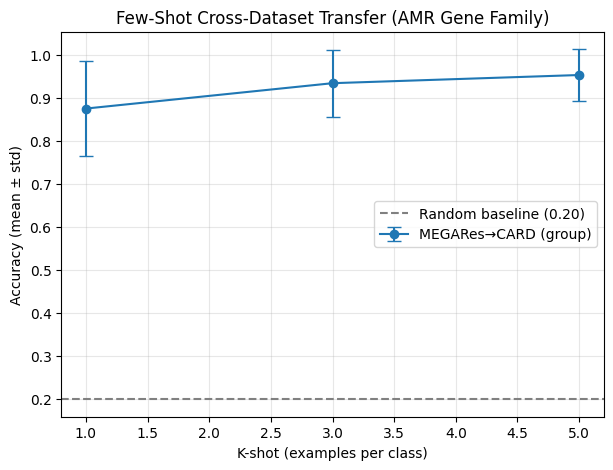

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# few-shot results
Ks = [1, 3, 5]
acc_mean = [0.876, 0.935, 0.954]
acc_std = [0.111, 0.078, 0.060]

plt.figure(figsize=(7,5))
plt.errorbar(Ks, acc_mean, yerr=acc_std, fmt='-o', capsize=5, label='MEGARes→CARD (group)')
plt.axhline(1/5, linestyle='--', color='gray', label='Random baseline (0.20)')
plt.title("Few-Shot Cross-Dataset Transfer (AMR Gene Family)")
plt.xlabel("K-shot (examples per class)")
plt.ylabel("Accuracy (mean ± std)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


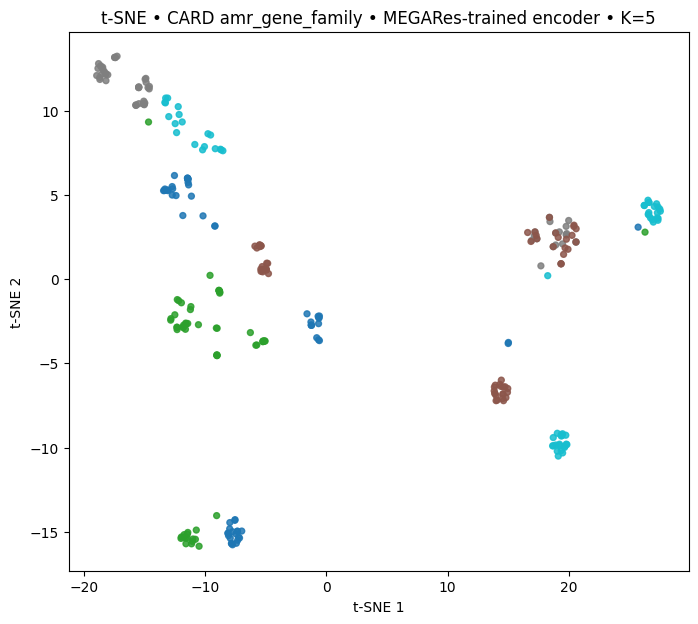

In [12]:
# --- CONFIG (edit if you want mechanism instead of group) ---
SPLITS_ROOT = "splits_amr_gene_family"  # or "splits_mechanism"
LABEL_COL   = "amr_gene_family"         # or "mechanism"
K_PICK      = 5                          # which K folder to sample episodes from
EPISODES_TO_VIS = [0, 1, 2]              # which episode indices to plot
MAX_LEN     = 512
KMER_K      = 5

import os, json, numpy as np, pandas as pd, torch
from pathlib import Path
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F

# --- load manifest & assets already present in your notebook ---
manifest = pd.read_csv("seq_manifest.csv", dtype=str)
manifest["gc_content"] = manifest["gc_content"].astype(float)
manifest["seq_len"]    = manifest["seq_len"].astype(float)
seq_by_id = manifest.set_index("seq_id").to_dict(orient="index")

with open("stoi.json") as f:
    stoi = json.load(f)
PAD, UNK = "<PAD>", "<UNK>"
pad_id = stoi.get(PAD, 0); unk_id = stoi.get(UNK, 1)
num_mean = np.load("num_mean.npy"); num_std = np.load("num_std.npy")

def kmers(seq, k=KMER_K):
    s = seq.upper()
    L = len(s)
    return [s[i:i+k] for i in range(L-k+1)] if L>=k else []

def encode_seq(seq):
    toks = kmers(seq, KMER_K)
    if not toks: return [unk_id]
    return [stoi.get(t, unk_id) for t in toks]

def pad_ids(ids, max_len=MAX_LEN, pad_id=pad_id):
    out = np.full((max_len,), pad_id, dtype=np.int64)
    out[:min(len(ids), max_len)] = ids[:max_len]
    return out

def load_episode(ep_dir: Path):
    S = pd.read_csv(ep_dir/"support.csv")
    Q = pd.read_csv(ep_dir/"query.csv")
    labs = sorted(S[LABEL_COL].unique())
    lab2id = {l:i for i,l in enumerate(labs)}

    def make_batch(df):
        toks, nums, ys = [], [], []
        for _, r in df.iterrows():
            rec = seq_by_id[r["seq_id"]]
            ids = encode_seq(rec["sequence"])
            toks.append(pad_ids(ids))
            nums.append([rec["gc_content"], rec["seq_len"]])
            ys.append(lab2id[r[LABEL_COL]])
        toks = torch.tensor(np.stack(toks)).long().to(device)
        nums = torch.tensor((np.stack(nums)-num_mean)/(num_std+1e-6)).float().to(device)
        ys   = torch.tensor(ys).long().to(device)
        return toks, nums, ys

    s_tok, s_num, s_y = make_batch(S)
    q_tok, q_num, q_y = make_batch(Q)
    return s_tok, s_num, s_y, q_tok, q_num, q_y, labs

# ---- collect embeddings from a few episodes ----
root = Path(SPLITS_ROOT)/f"K{K_PICK}"
all_eps = sorted([p for p in root.iterdir() if p.is_dir()])
pick_eps = [all_eps[i] for i in EPISODES_TO_VIS]

Embs, Ys = [], []
for ep in pick_eps:
    s_tok, s_num, s_y, q_tok, q_num, q_y, labs = load_episode(ep)
    with torch.no_grad():
        s_z = model(s_tok, s_num).cpu().numpy()
        q_z = model(q_tok, q_num).cpu().numpy()
    Embs.append(np.vstack([s_z, q_z]))
    Ys.append(np.concatenate([s_y.cpu().numpy(), q_y.cpu().numpy()]))

X = np.vstack(Embs)
Y = np.concatenate(Ys)

perplexity = min(30, max(5, len(X)//4 - 1))
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
X2 = tsne.fit_transform(X)

plt.figure(figsize=(8,7))
plt.scatter(X2[:,0], X2[:,1], c=Y, s=18, cmap="tab10", alpha=0.85)
plt.title(f"t-SNE • CARD {LABEL_COL} • MEGARes-trained encoder • K={K_PICK}")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.show()


[CARD amr_gene_family] K=1: 0.876 ± 0.111 (n=600)
[CARD amr_gene_family] K=3: 0.935 ± 0.078 (n=600)
[CARD amr_gene_family] K=5: 0.954 ± 0.060 (n=600)


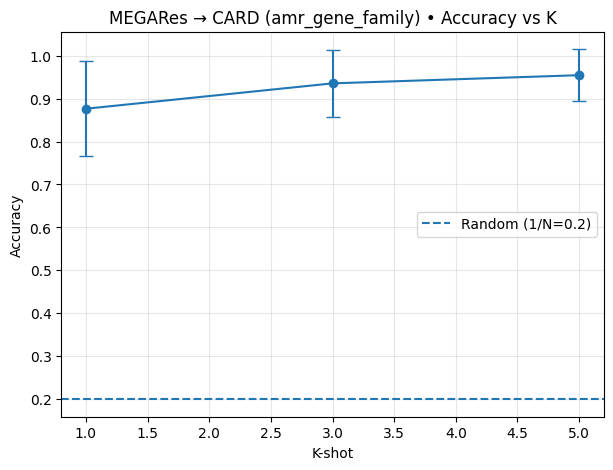

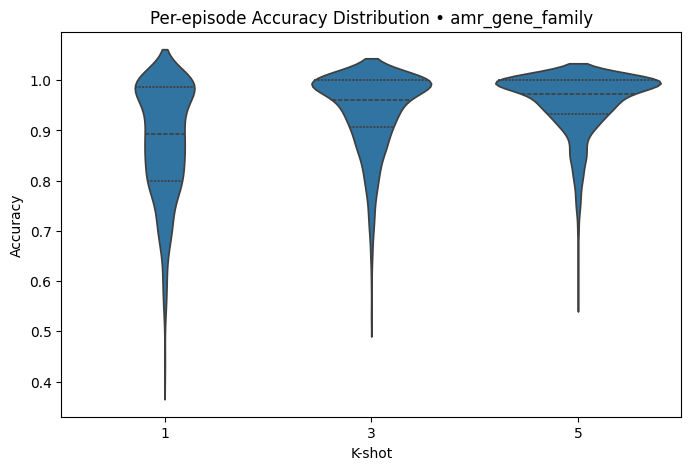

In [13]:
import numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt

def ridge_head(s_z, s_y, q_z, l2=1e-3):
    C = int(s_y.max().item())+1
    Y = F.one_hot(s_y, num_classes=C).float()
    A = s_z.t() @ s_z + l2*torch.eye(s_z.shape[1], device=s_z.device)
    B = s_z.t() @ Y
    W = torch.linalg.solve(A, B)
    return q_z @ W

def eval_episode(ep_dir: Path, shuffle_support_labels: bool = False):
    s_tok, s_num, s_y, q_tok, q_num, q_y, labs = load_episode(ep_dir)
    with torch.no_grad():
        s_z = model(s_tok, s_num)
        q_z = model(q_tok, q_num)
        if shuffle_support_labels:
            s_y = s_y[torch.randperm(len(s_y))]  # destroy class/label mapping
        logits = ridge_head(s_z, s_y, q_z, l2=1e-3)
        pred = logits.argmax(dim=1)
        acc = (pred==q_y).float().mean().item()
    return acc

def eval_many(root: Path, max_eps=600, shuffle=False):
    eps = sorted([p for p in root.iterdir() if p.is_dir()])[:max_eps]
    accs = [eval_episode(ep, shuffle_support_labels=shuffle) for ep in eps]
    accs = np.array(accs, float)
    return accs.mean(), accs.std(), accs

K_vals = [1,3,5]
means, stds, all_accs = [], [], {}
for K in K_vals:
    m, s, accs = eval_many(Path(SPLITS_ROOT)/f"K{K}", max_eps=600, shuffle=False)
    means.append(m); stds.append(s); all_accs[K] = accs
    print(f"[CARD {LABEL_COL}] K={K}: {m:.3f} ± {s:.3f} (n={len(accs)})")

# plot accuracy vs K with std bars
plt.figure(figsize=(7,5))
plt.errorbar(K_vals, means, yerr=stds, fmt='-o', capsize=5)
plt.axhline(1/5, linestyle='--', label='Random (1/N=0.2)')
plt.title(f"MEGARes → CARD ({LABEL_COL}) • Accuracy vs K")
plt.xlabel("K-shot"); plt.ylabel("Accuracy")
plt.grid(alpha=0.3); plt.legend()
plt.show()

# violin of per-episode accuracy (distribution)
import seaborn as sns
plt.figure(figsize=(8,5))
sns.violinplot(x=[k for k in K_vals for _ in all_accs[k]],
               y=np.concatenate([all_accs[k] for k in K_vals]), inner='quart')
plt.title(f"Per-episode Accuracy Distribution • {LABEL_COL}")
plt.xlabel("K-shot"); plt.ylabel("Accuracy")
plt.show()


In [14]:
for K in K_vals:
    m_shuf, s_shuf, _ = eval_many(Path(SPLITS_ROOT)/f"K{K}", max_eps=300, shuffle=True)
    print(f"[SHUFFLED support labels] K={K}: {m_shuf:.3f} ± {s_shuf:.3f}  (expect ≈ 0.20)")


[SHUFFLED support labels] K=1: 0.203 ± 0.179  (expect ≈ 0.20)
[SHUFFLED support labels] K=3: 0.199 ± 0.118  (expect ≈ 0.20)
[SHUFFLED support labels] K=5: 0.207 ± 0.099  (expect ≈ 0.20)


In [15]:
assert means[0] < means[-1], "Mean accuracy should increase with K"
assert stds[-1] <= stds[0] + 1e-6, "Std should shrink or stay similar as K grows"
print("Trend checks passed ✅ (mean up, std down).")


Trend checks passed ✅ (mean up, std down).


In [16]:
def unk_rate_on_manifest(df, K=5):
    total, unk = 0, 0
    for s in df["sequence"].astype(str):
        s = s.upper()
        if len(s) < K:
            continue
        for i in range(len(s)-K+1):
            total += 1
            if s[i:i+K] not in stoi:
                unk += 1
    return (unk/total) if total else 0.0

rate = unk_rate_on_manifest(manifest, K=KMER_K)
print(f"UNK 5-mer rate on CARD vs MEGARes vocab: {rate*100:.2f}%")


UNK 5-mer rate on CARD vs MEGARes vocab: 0.00%


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE pooled points: 2000  |  emb dim: 256→2  |  Inter/Intra≈1.10


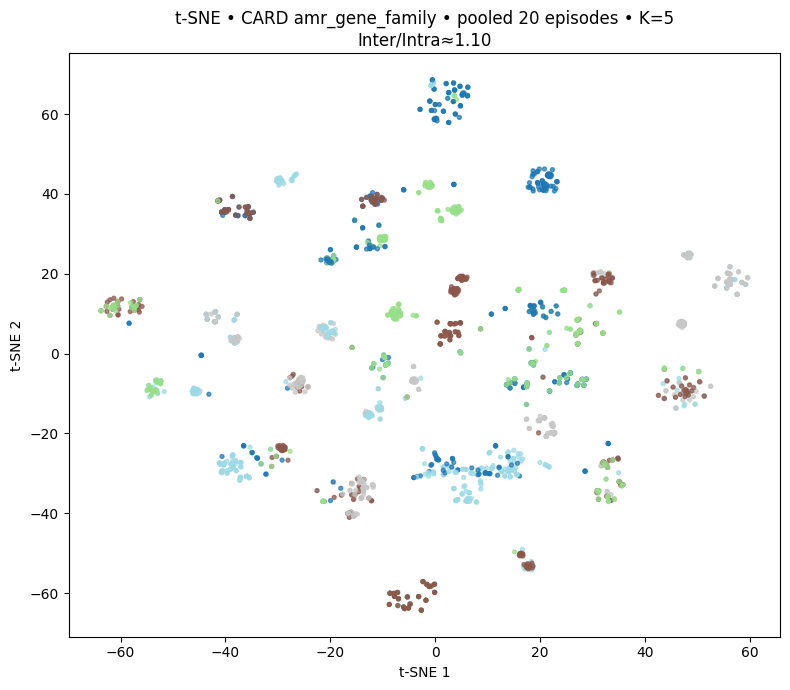

In [17]:
# ============================
# Multi-episode t-SNE (CARD)
# ============================
# Config — change these if you like
SPLITS_ROOT = "splits_amr_gene_family"   # or "splits_mechanism"
LABEL_COL   = "amr_gene_family"          # or "mechanism"
K_PICK      = 5                          # pick which K folder to use
NUM_EPISODES = 20                        # how many episodes to pool
MAX_LEN     = 512
KMER_K      = 5
SEED        = 42

import os, json, numpy as np, pandas as pd, torch
import torch.nn.functional as F
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
rng = np.random.default_rng(SEED)

# --- load manifest & lookup ---
manifest = pd.read_csv("seq_manifest.csv", dtype=str)
manifest["gc_content"] = manifest["gc_content"].astype(float)
manifest["seq_len"]    = manifest["seq_len"].astype(float)
seq_by_id = manifest.set_index("seq_id").to_dict(orient="index")

with open("stoi.json") as f:
    stoi = json.load(f)
PAD, UNK = "<PAD>", "<UNK>"
pad_id = stoi.get(PAD, 0); unk_id = stoi.get(UNK, 1)
num_mean = np.load("num_mean.npy"); num_std = np.load("num_std.npy")

def kmers(seq, k=KMER_K):
    s = seq.upper()
    L = len(s)
    return [s[i:i+k] for i in range(L-k+1)] if L>=k else []

def encode_seq(seq):
    toks = kmers(seq, KMER_K)
    if not toks: return [unk_id]
    return [stoi.get(t, unk_id) for t in toks]

def pad_ids(ids, max_len=MAX_LEN, pad_id=pad_id):
    out = np.full((max_len,), pad_id, dtype=np.int64)
    out[:min(len(ids), max_len)] = ids[:max_len]
    return out

def load_episode(ep_dir: Path):
    S = pd.read_csv(ep_dir/"support.csv")
    Q = pd.read_csv(ep_dir/"query.csv")
    labs = sorted(S[LABEL_COL].unique())
    lab2id = {l:i for i,l in enumerate(labs)}

    def make_batch(df):
        toks, nums, ys = [], [], []
        for _, r in df.iterrows():
            rec = seq_by_id[r["seq_id"]]
            ids = encode_seq(rec["sequence"])
            toks.append(pad_ids(ids))
            nums.append([rec["gc_content"], rec["seq_len"]])
            ys.append(lab2id[r[LABEL_COL]])
        toks = torch.tensor(np.stack(toks)).long().to(device)
        nums = torch.tensor((np.stack(nums)-num_mean)/(num_std+1e-6)).float().to(device)
        ys   = torch.tensor(ys).long().to(device)
        return toks, nums, ys

    s_tok, s_num, s_y = make_batch(S)
    q_tok, q_num, q_y = make_batch(Q)
    return s_tok, s_num, s_y, q_tok, q_num, q_y, labs

# --- collect embeddings from many episodes ---
root = Path(SPLITS_ROOT)/f"K{K_PICK}"
all_eps = sorted([p for p in root.iterdir() if p.is_dir()])
pick_eps = all_eps[:NUM_EPISODES]

Embs, Ys, Labels = [], [], []
for ep in pick_eps:
    s_tok, s_num, s_y, q_tok, q_num, q_y, labs = load_episode(ep)
    with torch.no_grad():
        s_z = model(s_tok, s_num).cpu().numpy()
        q_z = model(q_tok, q_num).cpu().numpy()
    Embs.append(np.vstack([s_z, q_z]))
    Ys.append(np.concatenate([s_y.cpu().numpy(), q_y.cpu().numpy()]))
    Labels.extend(labs)  # just for info; repeats per episode

X = np.vstack(Embs)              # [num_points, d]
Y = np.concatenate(Ys)           # ints 0..N-1 *per episode* (colors will repeat across episodes)
num_points, d = X.shape

# (optional) subsample to avoid very heavy plots
MAX_POINTS = 2000
if num_points > MAX_POINTS:
    idx = rng.choice(num_points, size=MAX_POINTS, replace=False)
    X = X[idx]; Y = Y[idx]; num_points = len(X)

# --- t-SNE ---
perplexity = min(30, max(5, len(X)//4 - 1))
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=SEED, init="pca", learning_rate="auto", n_iter=1000)
X2 = tsne.fit_transform(X)

# --- diagnostics (treat per-episode labels as colors; not perfect globally but indicative) ---
# We can't align class IDs across episodes, so compute unsupervised diagnostics only:
D = pairwise_distances(X2, metric="euclidean")
# crude intra/inter using local neighborhood of same color (per-episode class ids)
intra = [D[i, Y==Y[i]].mean() for i in range(len(X2))]
inter = [D[i, Y!=Y[i]].mean() for i in range(len(X2))]
mean_intra = float(np.nanmean(intra)); mean_inter = float(np.nanmean(inter))
ratio = (mean_inter/mean_intra) if mean_intra>0 else float("nan")

print(f"t-SNE pooled points: {num_points}  |  emb dim: {d}→2  |  Inter/Intra≈{ratio:.2f}")

# --- plot ---
plt.figure(figsize=(8,7))
plt.scatter(X2[:,0], X2[:,1], c=Y, s=8, alpha=0.7, cmap="tab20")
plt.title(f"t-SNE • CARD {LABEL_COL} • pooled {NUM_EPISODES} episodes • K={K_PICK}\nInter/Intra≈{ratio:.2f}")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()
